<h1>Analisi generale di un dataset di films</h1>

In questa prima parte ci occupiamo di eseguire le istruzioni necessarie per l'importazione di varie librerie e del dataset stesso.<br>
Inoltre visualizziamo il dataset a livello strutturale

In [55]:
#importiamo le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn.cluster as sk

#importiamo il dataset
dataset = pd.read_csv('mymoviedb.csv', lineterminator='\n')

#visualizziamo il dataset a livello strutturale
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9837 entries, 0 to 9836
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release_Date       9837 non-null   object 
 1   Title              9828 non-null   object 
 2   Overview           9828 non-null   object 
 3   Popularity         9827 non-null   float64
 4   Vote_Count         9827 non-null   object 
 5   Vote_Average       9827 non-null   object 
 6   Original_Language  9827 non-null   object 
 7   Genre              9826 non-null   object 
 8   Poster_Url         9826 non-null   object 
dtypes: float64(1), object(8)
memory usage: 691.8+ KB


In [56]:
#visualizziamo le prime righe del dataset per avere una visione più pratica
dataset.head()

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...


In [57]:
#vediamo i datatype delle colonne
dataset.dtypes

Release_Date          object
Title                 object
Overview              object
Popularity           float64
Vote_Count            object
Vote_Average          object
Original_Language     object
Genre                 object
Poster_Url            object
dtype: object

<h2>Pulizia del dataset</h2>

Procediamo con la prima parte: la pulizia del dataset, che ci permetterà di eseguire le analisi su di esso senza preoccuparci di possibili errori causati da datatype sbagliati, valori clonati o mancanti e colonne superflue.

In [58]:
#Togliamo poster_url
dataset = dataset.drop('Poster_Url', axis=1)

#Togliamo la colonna overview
dataset = dataset.drop('Overview', axis=1)

#troviamo i valori nulli nel dataset
dataset.isnull().sum()

Release_Date          0
Title                 9
Popularity           10
Vote_Count           10
Vote_Average         10
Original_Language    10
Genre                11
dtype: int64

Notiamo che ci sono dei valori nulli nel dataset, quindi procediamo a rimuoverli.
Supponendo che la maggior parte dei valori nulli siano correlati alle righe con titolo nullo, eliminiamo quindi prima i valori nulli in 'Title'

In [59]:
#eliminiamo i valori nulli di "title" 
dataset = dataset.dropna(subset=['Title'])

#visualizziamo le modifiche
dataset.isnull().sum()

Release_Date         0
Title                0
Popularity           1
Vote_Count           1
Vote_Average         1
Original_Language    1
Genre                2
dtype: int64

Effettivamente i valori nulli sono scesi drasticamente perchè tutti legati alle righe con titoli nulli. Ora, dato che rimangono poche righe con valori nulli, riteniamo sia legittimo rimuoverle direttamente perchè poco influenti.

In [60]:
dataset = dataset.dropna()

Adesso controlliamo se ci sono valori duplicati e nel caso li eliminiamo 

In [61]:
dataset.duplicated().sum()

0

Come possiamo vedere, non sono presenti valori duplicati

<h3>Conversione dei datatype </h3>
Per permettere la analisi dei dati, è necessaria la conversione dei datatype di alcune colonne

In [62]:
#convertiamo il datatype di 'Vote_average' a float e 'Vote_count' ad int
dataset['Vote_Count'] = dataset['Vote_Count'].astype(int, copy=False)
dataset['Vote_Average'] = dataset['Vote_Average'].astype(float, copy=False)
dataset.Release_Date = pd.to_datetime(dataset.Release_Date)

dataset.describe()
dataset.dtypes

Release_Date         datetime64[ns]
Title                        object
Popularity                  float64
Vote_Count                    int64
Vote_Average                float64
Original_Language            object
Genre                        object
dtype: object

<h1>Visualizzazione</h1>

Per poter eseguire l'olap abbiamo prima bisogno di quantizzare tre valori per noi significativi e utili per l'analisi del dataset. 
In questo caso la scelta migliore ci è sembrata quella di quantizzare popularity, vote_average e release_date.

Per poter quantizzare nel modo migliore la popolarità, la visualizziamo in un grafico

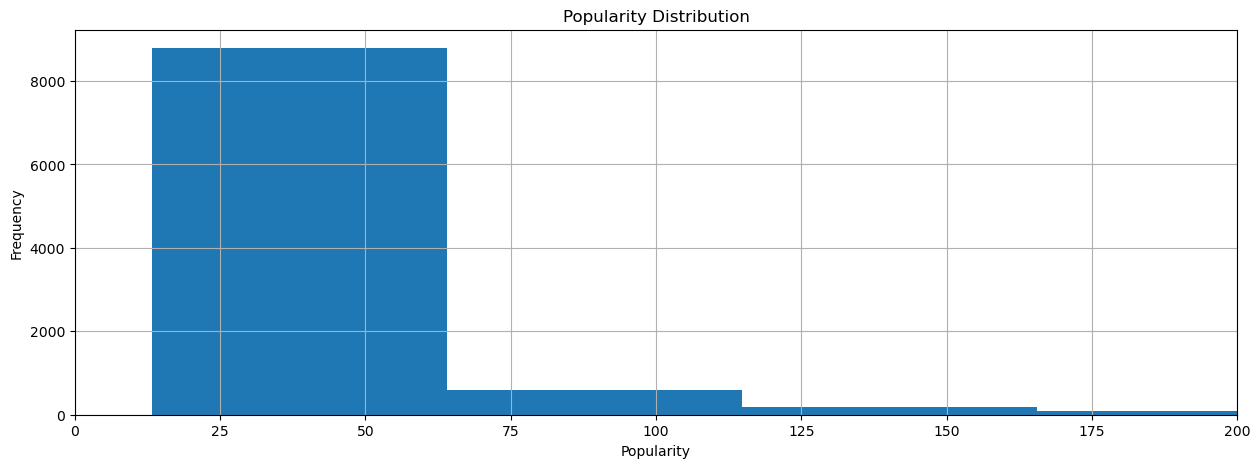

In [63]:
#visuallizziamo la distribuzione di 'Popularity'
histo = dataset['Popularity'].hist(bins=100, figsize=(15, 5))
plt.xlim(0, 200) #limitiamo l'asse y per una migliore visualizzazione
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Popularity Distribution')
plt.show()

Come possiamo vedere sono presenti più di 8000 film sotto la popolarità 60, mentre sopra questa soglia sono presenti molti meno film 

Invece per quantizzare release_date visuliazziamo qualche informazione sulla data di uscita dei film

In [64]:
#vediamo il titolo delfilm meno recente e il più recente
dataset.Release_Date = pd.to_datetime(dataset.Release_Date)
min_date = dataset['Release_Date'].min()
max_date = dataset['Release_Date'].max()

print('Il film meno recente è:', dataset[dataset['Release_Date'] == min_date]['Title'].values[0], ', uscito il', min_date.date())
print('Il film più recente è:', dataset[dataset['Release_Date'] == max_date]['Title'].values[0], ', uscito il', max_date.date())


Il film meno recente è: A Trip to the Moon , uscito il 1902-04-17
Il film più recente è: Despicable Me 4 , uscito il 2024-07-03


Come possiao notare, nel database sono presenti dei film che non sono ancora usciti ma hanno già una data di pubblicazione ufficiale

Ora scegliamo effettivamente come quantizzare le colonne scelte

Quantizzazione delle date di uscita
1. VERY OLD = [1900, 1980]
2. OLD = [1981, 2000]
3. RECENT = [2001, 2015]
4. VERY RECENT = [2016, 2024]

Quantizziamo anche i voti
1. BAD = [0, 4.9]
2. SUFFICIENT = [5, 5.9]
3. GOOD = [6, 6.9]
4. VERY GOOD = [7, 7.9]
5. EXCELLENT = [8, 10]

Quantizziamo anche popularity
1. NOT POPULAR = [0 ,39.9] 
2. AVARAGE = [40, 59.9]
3. POPULAR = [60, 1999.9]
4. BLOCKBUSTER = [2000, 5084]

In [65]:
quantize_release_date = ['VERY OLD', 'OLD', 'RECENT', 'VERY RECENT']
minimum = [1900, 1981, 2001, 2016]
maximum = [1980, 2000, 2015, 2024]

for i in range(4):
    dataset.loc[dataset['Release_Date'].dt.year.between(minimum[i], maximum[i]), 'quant_Release_Date'] = quantize_release_date[i]

In [66]:
#Quantizziamo la colonna 'Vote_Average'
quantize_vote_average = ['VERY BAD', 'BAD', 'SUFFICIENT', 'GOOD', 'VERY GOOD']
minimum = [0, 5, 6, 7, 8]
maximum = [4.9, 5.9, 6.9, 7.9, 10]


for i in range(5):
    dataset.loc[dataset['Vote_Average'].between(minimum[i], maximum[i]), 'quant_vote_average'] = quantize_vote_average[i]


In [67]:
#Abbiamo notato che alcuni valori di Popularity hanno molte cifre decimali, quindi abbiamo deciso di arrotondarli a 1 cifra decimale
dataset['Popularity'] = dataset['Popularity'].round(1)


#Quantizziamo la colonna 'Popularity'
quantize_popularity = ['NOT POPULAR', 'AVERAGE', 'POPULAR', 'BLOCKBUSTER']
minimum = [0, 40, 60, 2000]
maximum = [39.9, 59.9, 1999.9, 5084]

for i in range(4):
    dataset.loc[dataset['Popularity'].between(minimum[i], maximum[i]), 'quant_popularity'] = quantize_popularity[i]
    


Visualizziamo il dataset per controllare le nuove colonne quantizzate

In [68]:
dataset.describe()
dataset.head(10)


,Release_Date,Title,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,quant_Release_Date,quant_vote_average,quant_popularity
0,2021-12-15,Spider-Man: No Way Home,5084.0,8940,8.3,en,"Action, Adventure, Science Fiction",VERY RECENT,VERY GOOD,BLOCKBUSTER
1,2022-03-01,The Batman,3827.7,1151,8.1,en,"Crime, Mystery, Thriller",VERY RECENT,VERY GOOD,BLOCKBUSTER
2,2022-02-25,No Exit,2618.1,122,6.3,en,Thriller,VERY RECENT,SUFFICIENT,BLOCKBUSTER
3,2021-11-24,Encanto,2402.2,5076,7.7,en,"Animation, Comedy, Family, Fantasy",VERY RECENT,GOOD,BLOCKBUSTER
4,2021-12-22,The King's Man,1895.5,1793,7.0,en,"Action, Adventure, Thriller, War",VERY RECENT,GOOD,POPULAR
5,2022-01-07,The Commando,1750.5,33,6.6,en,"Action, Crime, Thriller",VERY RECENT,SUFFICIENT,POPULAR
6,2022-01-12,Scream,1675.2,821,6.8,en,"Horror, Mystery, Thriller",VERY RECENT,SUFFICIENT,POPULAR
7,2022-02-10,Kimi,1601.8,206,6.3,en,Thriller,VERY RECENT,SUFFICIENT,POPULAR
8,2022-02-17,Fistful of Vengeance,1594.0,114,5.3,en,"Action, Crime, Fantasy",VERY RECENT,BAD,POPULAR
9,2021-11-03,Eternals,1537.4,4726,7.2,en,Science Fiction,VERY RECENT,GOOD,POPULAR


<h2>OLAP</h2>

Adesso implementiamo l'OLAP per il nostro dataset, utilizzando le colonne quantizzate .
L'OLAP è utile per diverse ragioni perchè consente di visualizzare i dati da diverse prospettive, organizzandoli in dimensioni multiple. Inoltre è ottimizzato per consentire l'accesso rapido ai dati. 

In [69]:
OLAP = np.zeros((len(quantize_popularity), len(quantize_release_date), len(quantize_vote_average)))
for z in range(0, len(quantize_popularity)):
    for j in range(0, len(quantize_release_date)):
        for i in range(0, len(quantize_vote_average)):
            OLAP[z, j, i] = ((dataset['quant_popularity'] == quantize_popularity[z]) & 
                             (dataset['quant_Release_Date'] == quantize_release_date[j]) &
                             (dataset['quant_vote_average'] == quantize_vote_average[i])).sum()

np.set_printoptions(suppress=True)        
print(quantize_popularity)
print(quantize_release_date)
print(quantize_vote_average)
print("\n")
print(OLAP)

['NOT POPULAR', 'AVERAGE', 'POPULAR', 'BLOCKBUSTER']
['VERY OLD', 'OLD', 'RECENT', 'VERY RECENT']
['VERY BAD', 'BAD', 'SUFFICIENT', 'GOOD', 'VERY GOOD']


[[[  16.   52.  193.  333.   76.]
  [  76.  306.  737.  439.   39.]
  [ 201.  798. 1343.  727.   60.]
  [ 220.  515.  938.  608.  100.]]

 [[   0.    1.    4.   13.    9.]
  [   1.   12.   31.   48.   14.]
  [  17.   86.  208.  115.   16.]
  [  12.   52.  148.   92.   24.]]

 [[   0.    1.    1.   13.    3.]
  [   3.    6.   23.   26.   13.]
  [   8.   54.  164.  130.   16.]
  [  39.   91.  242.  245.   64.]]

 [[   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    0.    0.    0.]
  [   0.    0.    1.    1.    2.]]]


le "micro-matrici' sono il livello di popularity, le righe sono il livello di release_date e le colonne riguardano il livello di Vote_average.


Procediamo allo slicing dell'olap, in modo da visualizzare la matrice dei film POPULAR

In [70]:
POP_MOVIE = OLAP[2]
print(POP_MOVIE)

[[  0.   1.   1.  13.   3.]
 [  3.   6.  23.  26.  13.]
 [  8.  54. 164. 130.  16.]
 [ 39.  91. 242. 245.  64.]]


<h3>Heatmap</h3>
Creiamo una heatmap che ci consente di visualizzare rapidamente come variano i valori della matrice dei film popolari. 

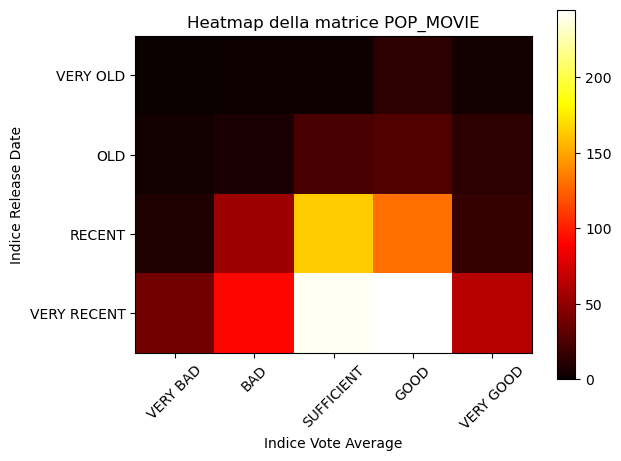

In [71]:
plt.imshow(POP_MOVIE, cmap='hot', interpolation='nearest')
plt.colorbar()  # Aggiunge una barra dei colori per indicare il valore
plt.title('Heatmap della matrice POP_MOVIE')
plt.xlabel('Indice Vote Average')
plt.xticks(range(len(quantize_vote_average)), quantize_vote_average, rotation=45)
plt.yticks(range(len(quantize_release_date)), quantize_release_date)
plt.ylabel('Indice Release Date')
plt.show()

Si può vedere per esempio che i film popolari molto vecchi e con recensioni negative sono quasi nulli, mentre il cluster più popolato è quello dei film molto recenti con voti dal sufficiente in su

Ora facciamo un dicing in modo da visualizzare i film VERY RECENT con votazione media SUFFICIENT

In [72]:
SUFFICIENT_and_VERYRECENT = OLAP[:,3,2]

print(SUFFICIENT_and_VERYRECENT)

[938. 148. 242.   1.]


Visualizziamolo con un grafico a barre 

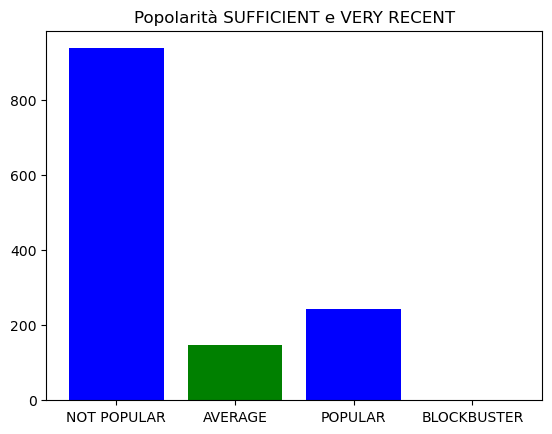

In [73]:
# Grafico a barre con l'indice sull'asse x e il valore sull'asse y
plt.bar(range(len(SUFFICIENT_and_VERYRECENT)), SUFFICIENT_and_VERYRECENT, color=['blue', 'green'])  

# Nomi delle categorie sugli assi x
plt.xticks(range(len(SUFFICIENT_and_VERYRECENT)), ['NOT POPULAR', 'AVERAGE', 'POPULAR', 'BLOCKBUSTER'])
  
# Titolo del grafico
plt.title('Popolarità SUFFICIENT e VERY RECENT')

# Mostra il grafico
plt.show()

Si può facilemnte vedere che i blockbuster con votazione media e recenti sono praticamente assenti, mentre quelli non popolari sono moltissimi.

<h1>Test statistico</h1>


Analizziamo la differenza dei voti medi in base al periodo di uscita dei film

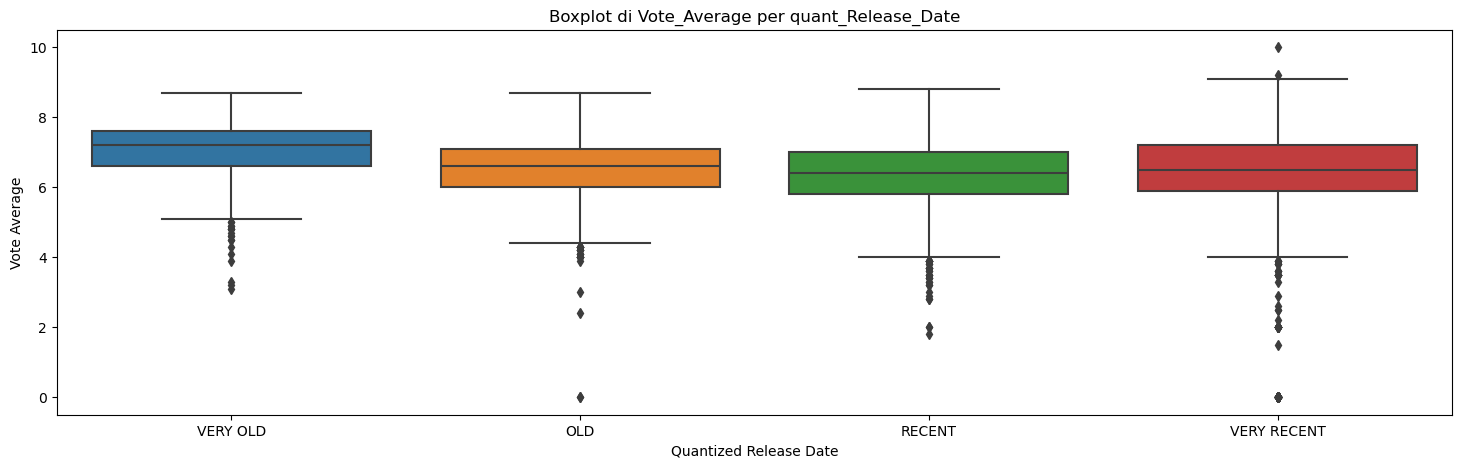

In [74]:
# Crea il boxplot con le etichette sull'asse x nell'ordine desiderato
plt.figure(figsize=(18, 5))
sns.boxplot(data=dataset, x='quant_Release_Date', y='Vote_Average', order= ['VERY OLD', 'OLD', 'RECENT', 'VERY RECENT'])
plt.title('Boxplot di Vote_Average per quant_Release_Date') 
plt.xlabel('Quantized Release Date')
plt.ylabel('Vote Average')
plt.show()

Il grafico evidenzia una somiglianza tra i film vecchi e quelli molto recenti, per cui procediamo a verificare con un test statistico

In [75]:
#Verifichiamo che la quantità di elementi nelle classi OLD e VERY RECENT sia bilanciata
old_count = dataset[dataset['quant_Release_Date'] == 'OLD'].shape[0]
very_recent_count = dataset[dataset['quant_Release_Date'] == 'VERY RECENT'].shape[0]

print("Number of elements in class OLD:", old_count)
print("Number of elements in class VERY RECENT:",very_recent_count)

Number of elements in class OLD: 1774
Number of elements in class VERY RECENT: 3394


In [76]:
old_count = dataset[dataset['quant_Release_Date'] == 'OLD']["Vote_Average"]
very_recent_count = dataset[dataset['quant_Release_Date'] == 'VERY RECENT']["Vote_Average"]

# Perform t-test
t_stat, p_value = stats.ttest_ind(old_count, very_recent_count)

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")
#DA VERIFICARE

T-statistic: 5.127906522153585
P-value: 3.036758000146715e-07
Reject the null hypothesis.


Rigettiamo l'analisi nulla, però per accettare la tesi opposta sarebbe necessario un P-value decisamente minore di quello ottenuto.

Possiamo affermare che i film usciti recentemente hanno un voto medio non uguale a quelli usciti molto tempo fa, ma non possiamo dire che abbiano un voto medio diverso.

<h1>Metodo predittivo</h1>

Ora vogliamo fare delle valutazioni in base al genere dei film.

Prima però è necessario trasformare la colonna Genre in modo che abbia un solo genere per film

In [77]:
dataset["Genre"] = dataset["Genre"].str.split(',').str[0]
dataset.head()

,Release_Date,Title,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,quant_Release_Date,quant_vote_average,quant_popularity
0,2021-12-15,Spider-Man: No Way Home,5084.0,8940,8.3,en,Action,VERY RECENT,VERY GOOD,BLOCKBUSTER
1,2022-03-01,The Batman,3827.7,1151,8.1,en,Crime,VERY RECENT,VERY GOOD,BLOCKBUSTER
2,2022-02-25,No Exit,2618.1,122,6.3,en,Thriller,VERY RECENT,SUFFICIENT,BLOCKBUSTER
3,2021-11-24,Encanto,2402.2,5076,7.7,en,Animation,VERY RECENT,GOOD,BLOCKBUSTER
4,2021-12-22,The King's Man,1895.5,1793,7.0,en,Action,VERY RECENT,GOOD,POPULAR


Visualizziamo lo scatter plot dei generi e la loro popolarità

Text(0.5, 0, 'Genre')

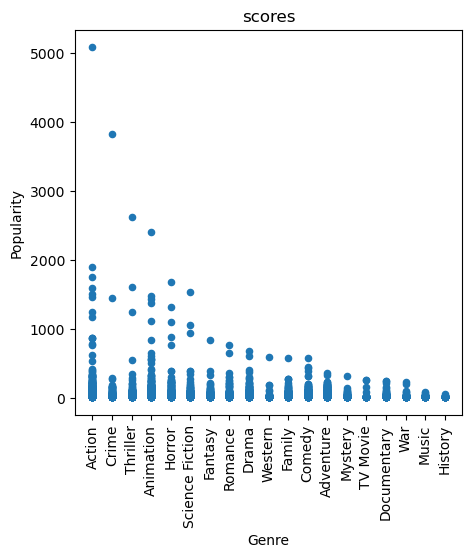

In [78]:
dataset.plot(kind ='scatter',y='Popularity', x='Genre', figsize = (5,5))
plt.xticks(rotation=90)
plt.title('scores')
plt.ylabel('Popularity')
plt.xlabel('Genre')

In [79]:
#Vediamo se c'è correlazione tra generi e Vote_Average
#Per rendere le colonne confrontabili, mappiamo i generi in valori numerici
genre_mapping = {'Action': 1, 'Crime': 2, 'Thriller': 3, 'Animation': 4, 
                 'Horror': 5, 'Science Fiction': 6, 'Fantasy': 7, 'Romance': 8,
                'Drama': 9, 'Western': 10, 'Family': 11, 'Comedy': 12, 
                 'Adventure': 13, 'Mystery': 14, 'TV Movie': 15,'Documentary': 16,
                 'War': 17, 'Music': 18,'History': 19}

# Map genre column to numerical values
dataset['genre_encoded'] = dataset['Genre'].map(genre_mapping)

correlation = dataset[['genre_encoded','Popularity']].corr()
print(correlation)

               genre_encoded  Popularity
genre_encoded       1.000000   -0.082829
Popularity         -0.082829    1.000000


Al contrario di come ci aspettavamo, il genere di un film è molto poco correlato alla sua popolarità, tuttavia anche se consci del fatto che il modello predittivo non sarebbe venuto preciso, abbiamo ritenuto interessante verificare se fosse possibile dedurre dal genere di un film la popolarità 

<h2>Regressione lineare</h2>
<h3>Normalizzazione</h3>

Dato che i valori che vogliamo utilizzare per la regressione lineare sono in scala diversa, è necessario normalizzare i dati

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#Normalizziamo per rendere le colonne confrontabili
features_to_normalize = ["genre_encoded", "Popularity"]
film_normalized = dataset[features_to_normalize].copy()


scaler = MinMaxScaler()

film_normalized[features_to_normalize] = scaler.fit_transform(film_normalized[features_to_normalize])
# Definire le caratteristiche da usare
#Cerchiamo di predirre la popolarità in base al numero di voti
features = ['genre_encoded']

# Definire X e y
X = film_normalized[features]
y = film_normalized['Popularity']

# Dividere il dataset in training e validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2)


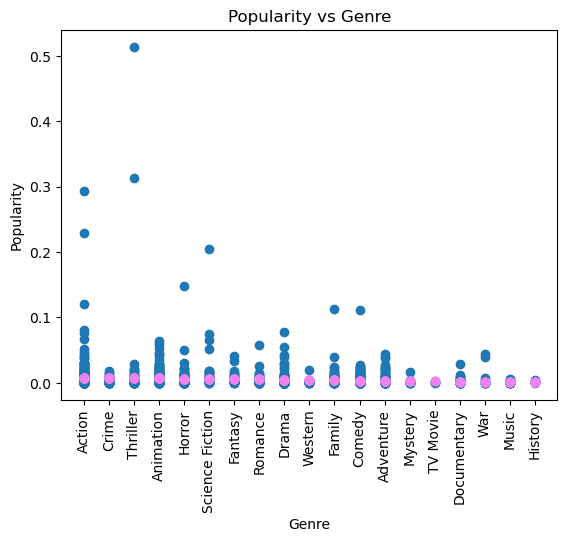

In [81]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

reg = regressor.fit(X_train, y_train)
y_pred = reg.coef_ * X_valid + reg.intercept_

plt.scatter(X_valid, y_valid)
plt.scatter(X_valid, y_pred, color="violet")
plt.xlabel('Genre')
plt.xticks(rotation=90)
plt.xticks(ticks=[0, 1/18, 2/18, 3/18, 4/18, 5/18, 6/18, 7/18, 8/18, 9/18,10/18, 11/18, 12/18, 13/18, 14/18, 15/18, 16/18, 17/18, 18/18], 
            labels=['Action', 'Crime', 'Thriller', 'Animation', 
                 'Horror', 'Science Fiction', 'Fantasy', 'Romance',
                 'Drama', 'Western', 'Family', 'Comedy', 
                 'Adventure', 'Mystery', 'TV Movie','Documentary',
                 'War', 'Music','History'])
plt.ylabel('Popularity')
plt.title('Popularity vs Genre')
plt.show()

(0.0, 0.04)

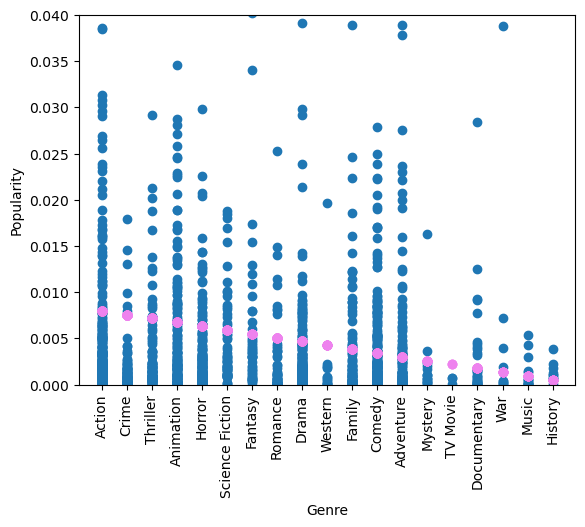

In [82]:
#Sembrano identici, ma se li vediamo più in dettaglio
plt.scatter(X_valid,y_valid)
plt.scatter(X_valid,y_pred,color="violet")
plt.xticks(rotation=90)
plt.xticks(ticks=[0, 1/18, 2/18, 3/18, 4/18, 5/18, 6/18, 7/18, 8/18, 9/18,10/18, 11/18, 12/18, 13/18, 14/18, 15/18, 16/18, 17/18, 18/18], labels=['Action', 'Crime', 'Thriller', 'Animation', 
                 'Horror', 'Science Fiction', 'Fantasy', 'Romance',
                 'Drama', 'Western', 'Family', 'Comedy', 
                 'Adventure', 'Mystery', 'TV Movie','Documentary',
                 'War', 'Music','History'])
plt.xlabel('Genre')
plt.ylabel('Popularity')
plt.ylim(0, 0.04)

(0.0, 0.04)

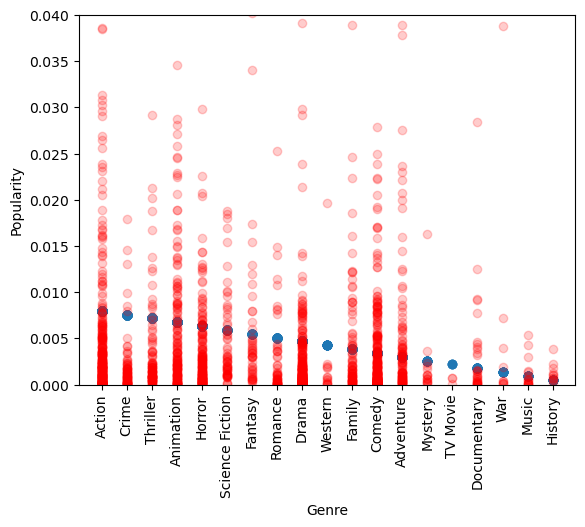

In [83]:
y_hat = reg.predict(X_valid)
plt.scatter(X_valid,y_hat)
plt.scatter(X_valid,y_valid,c='r',alpha=0.2)
plt.xlabel('Genre')
plt.xticks(rotation=90)
plt.xticks(ticks=[0, 1/18, 2/18, 3/18, 4/18, 5/18, 6/18, 7/18, 8/18, 9/18,10/18, 11/18, 12/18, 13/18, 14/18, 15/18, 16/18, 17/18, 18/18], labels=['Action', 'Crime', 'Thriller', 'Animation', 
                 'Horror', 'Science Fiction', 'Fantasy', 'Romance',
                 'Drama', 'Western', 'Family', 'Comedy', 
                 'Adventure', 'Mystery', 'TV Movie','Documentary',
                 'War', 'Music','History'])
plt.ylabel('Popularity')
plt.ylim(0, 0.04)

In [84]:
from sklearn import metrics

print ('MAE:', metrics.mean_absolute_error(y_hat, y_valid))
print ('MSE:', metrics.mean_squared_error(y_hat, y_valid))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_hat, y_valid)))

MAE: 0.006182874442580568
MSE: 0.00036049642659789473
RMSE: 0.01898674344372659


Confrontiamo con il modello nullo

In [85]:
#calcolate lo score medio
mean_vote = y_train.mean()

# create la nuova x con lo stesso numero di campioni del validation set originale, e con tutti i valori uguali al valore medio dello score appena calcolato
null_model_y = np.ones(len(y_valid))*mean_vote
print ('MAE:', metrics.mean_absolute_error(null_model_y, y_valid))
print ('MSE:', metrics.mean_squared_error(null_model_y, y_valid))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(null_model_y, y_valid)))

MAE: 0.006046998786490749
MSE: 0.00036199197946136855
RMSE: 0.0190260868141972


Notiamo che il nostro modello non è molto lontano da un modello nullo, quindi possiamo dedurre che il genere del film non sia correlato alla popolarità e che quindi sia molto difficile capire la popolarità in base al genere

<h1>Clustering </h2>

Realizziamo il grafico della silhouette per trovare il numero ottimale di cluster

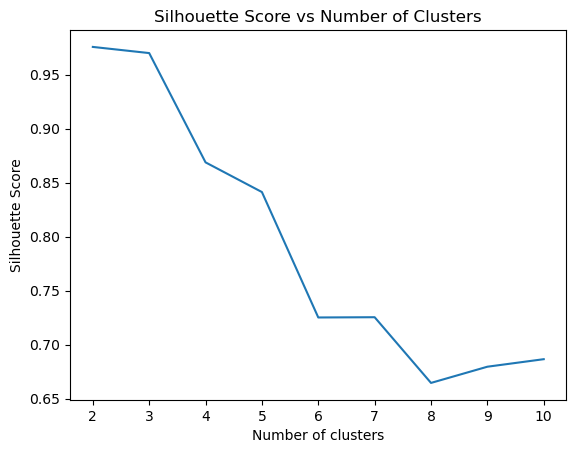

In [86]:
from sklearn import metrics
release_mapping = {'VERY OLD': 1, 'OLD': 2, 'RECENT': 3, 'VERY RECENT': 4}

# Map genre column to numerical values
dataset['release_encoded'] = dataset['quant_Release_Date'].map(release_mapping)

#Facciamo silhuette per vedere il numero di cluster
X = dataset[['Vote_Average', 'Popularity', 'release_encoded', 'genre_encoded']]
sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans = sk.KMeans(n_clusters=k, n_init=kmax).fit(X)
    labels = kmeans.labels_
    sil.append(metrics.silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(range(2, kmax+1), sil)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

Vediamo quanto sono correlate la popolarità e il voto medio

In [87]:
correlation = dataset[['Vote_Average','Popularity']].corr()
print(correlation)

              Vote_Average  Popularity
Vote_Average      1.000000    0.053837
Popularity        0.053837    1.000000


Clusterizziamo il dataset basandoci sulle colonne che riteniamo influenti. Nel nostro caso ["Popularity", "Vote_Average","genre_encoded","release_encoded"]. Inoltre ne visualizziamo il grafico con Popolarità e vote average come assi.


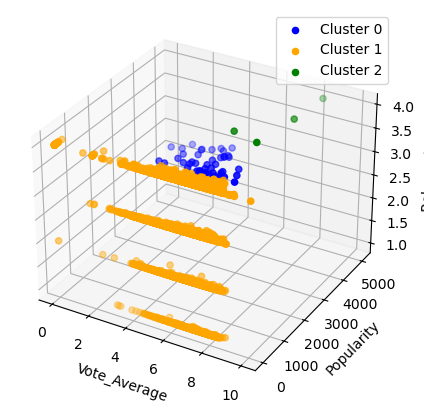

In [99]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'dataset' contains your data
# Ensure you have imported necessary libraries like pandas and sklearn

# Your KMeans clustering code
kmeans = sk.KMeans(n_clusters=3, random_state=1, n_init=kmax)
clusters = kmeans.fit_predict(dataset[["Popularity", "Vote_Average","genre_encoded","release_encoded"]])
dataset["cluster"] = clusters

# Plotting in 3D
fig = plt.figure(figsize=(5, 5))
plt.tight_layout()
ax = fig.add_subplot(111, projection='3d')

color = ['b','orange','g']

for i in range(0, 3):
    ax.scatter(dataset.loc[dataset['cluster'] == i, 'Vote_Average'], 
               dataset.loc[dataset['cluster'] == i, 'Popularity'], 
               dataset.loc[dataset['cluster'] == i, 'release_encoded'], 
               color=color[i], label='Cluster ' + str(i))

ax.set_xlabel('Vote_Average')
ax.set_ylabel('Popularity')
ax.set_zlabel('Release Year')
ax.legend()
plt.show()


Molto interessante 